# Adagrad
这个优化算法被称为自适应学习率优化算法，之前我们讲的随机梯度下降以及动量法对所有的参数都使用的固定的学习率进行参数更新，但是不同的参数梯度可能不一样，所以需要不同的学习率才能比较好的进行训练，但是这个事情又不能很好地被人为操作，所以 Adagrad 便能够帮助我们做这件事。

## Adagrad 算法
Adagrad 的想法非常简答，在每次使用一个 batch size 的数据进行参数更新的时候，我们需要计算所有参数的梯度，那么其想法就是对于每个参数，初始化一个变量 s 为 0，然后每次将该参数的梯度平方求和累加到这个变量 s 上，然后在更新这个参数的时候，学习率就变为

$$
\frac{\eta}{\sqrt{s + \epsilon}}
$$

这里的 $\epsilon$ 是为了数值稳定性而加上的，因为有可能 s 的值为 0，那么 0 出现在分母就会出现无穷大的情况，通常 $\epsilon$ 取 $10^{-10}$，这样不同的参数由于梯度不同，他们对应的 s 大小也就不同，所以上面的公式得到的学习率也就不同，这也就实现了自适应的学习率。



Adagrad 的核心想法就是，如果一个参数的梯度一直都非常大，那么其对应的学习率就变小一点，防止震荡，而一个参数的梯度一直都非常小，那么这个参数的学习率就变大一点，使得其能够更快地更新

Adagrad 也有一些问题，因为 s 不断累加梯度的平方，所以会越来越大，导致学习率在后期会变得较小，导致收敛乏力的情况，可能无法收敛到表较好的结果，当然后面有一个对其的改进，我们之后会讲到

下面我们来实现一下 Adagrad 的算法

In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf
import numpy as np
import time
import tensorflow.examples.tutorials.mnist.input_data as input_data

import sys
sys.path.append('..')
# from utils.layers import hidden_layer, DNN

tf.set_random_seed(2017)

In [2]:
# 神经网络构建
def hidden_layer(layer_input, output_depth, scope='hidden_layer', reuse=None):
    input_depth = layer_input.get_shape()[-1]
    with tf.variable_scope(scope, reuse=reuse):
        # 注意这里的初始化方法是truncated_normal
        w = tf.get_variable(initializer=tf.truncated_normal_initializer(stddev=0.1), shape=(input_depth, output_depth), name='weights')
        # 注意这里用 0.1 对偏置进行初始化
        b = tf.get_variable(initializer=tf.constant_initializer(0.1), shape=(output_depth), name='bias')
        net = tf.matmul(layer_input, w) + b
        
        return net

def DNN(x, output_depths, scope='DNN', reuse=None):
    net = x
    for i, output_depth in enumerate(output_depths):
        net = hidden_layer(net, output_depth, scope='layer%d' % i, reuse=reuse)
        # 注意这里的激活函数
        net = tf.nn.relu(net)
    # 数字分为0, 1, ..., 9 所以这是10分类问题
    # 对应于 one_hot 的标签, 所以这里输出一个 10维 的向量
    net = hidden_layer(net, 10, scope='classification', reuse=reuse)
    
    return net

In [3]:
# 数据导入
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

train_set = mnist.train
test_set = mnist.test

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
# 定义模型
input_ph = tf.placeholder(shape=(None, 784), dtype=tf.float32)
label_ph = tf.placeholder(shape=(None, 10), dtype=tf.int64)

# dnn = DNN(input_ph, [200], weights_collection='params', biases_collection='params')
dnn = DNN(input_ph, [200])

In [5]:
# 构建`loss`和`acc`
loss = tf.losses.softmax_cross_entropy(logits=dnn, onehot_labels=label_ph)

acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn, axis=-1), tf.argmax(label_ph, axis=-1)), dtype=tf.float32))

In [6]:
sess = tf.InteractiveSession()

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

### tf.train.AdagradOptimizer
`tensorflow`中也集成了`adagrad`方法

In [8]:
train_op = tf.train.AdagradOptimizer(0.01).minimize(loss)

In [9]:
batch_size = 64

sess.run(tf.global_variables_initializer())

train_losses1 = []

epoch = 0
samples_passed = 0
epoch_done = False
step = 0

_start = time.time()
while (epoch < 5):
    if samples_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - samples_passed
        samples_passed = 0
        epoch += 1
        epoch_done = True
    else:
        samples_passed += batch_size
        this_batch = batch_size
        
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(this_batch)
    if epoch_done:
        # 计算所有训练样本的损失值
        train_loss = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train = sess.run(loss, feed_dict={input_ph: image, label_ph: label})
            train_loss.append(loss_train)

        print('Epoch {} Train loss: {:.6f}'.format(epoch, np.array(train_loss).mean()))
        epoch_done = False
        
    # 每30步记录一次训练误差
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses1.append(loss_train)
        
    sess.run(train_op, feed_dict={input_ph: images, label_ph: labels})
    step += 1

_end = time.time()
print('Train Done! Cost Time: {:.2f}s'.format(_end - _start))

Epoch 1 Train loss: 0.348825
Epoch 2 Train loss: 0.287115
Epoch 3 Train loss: 0.252545
Epoch 4 Train loss: 0.229835
Epoch 5 Train loss: 0.210603
Train Done! Cost Time: 22.61s


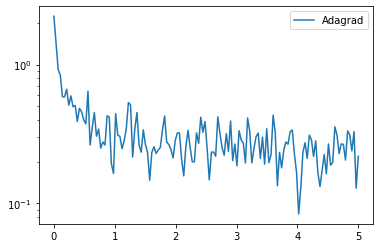

In [10]:
x_axis = np.linspace(0, 5, len(train_losses1), endpoint=True)
plt.semilogy(x_axis, train_losses1, label='Adagrad')
plt.legend(loc='best')